# 3IO-PCEX (IOPC)

Model 30IO-PCEX was introduced by Marco Veronese Passarella as a simple pedagogical model and intermediate step towards an environmentally extended stock-flow consistent (SFC) input-output (IO) model (see the [source repository](https://github.com/marcoverpas/keynote_speech_Florence/blob/main/README.md#21---model-pc)). This implementation by Karl Naumann-Woleske extends the model to use the expectation version of model PC.

## Model Overview

The remainder of this page gives an introduction to the model, notes on how it is implemented in `MacroStat` and then shows some of the model dynamics using the default parameters. Unfortunately they are alphabetic from the export

1. Central Bank Bill Holdings

$$
	\begin{align}
	B_{CB}(t) = B_{s}(t) - B_{h}(t)
	\end{align}
$$



2. Central Bank Money Stock

$$
	\begin{align}
	H_{s}(t) = H_{s}(t-1) + (B_{CB}(t) - B_{CB}(t-1))
	\end{align}
$$

3. Central Bank Profits

$$
	\begin{align}
	r(t-1)B_{CB}(t-1)
	\end{align}
$$

4. Consumption (note that here we have the case that we are computing _real_ consumption, i.e. expected nominal income divided by the household CPI)

$$
	\begin{align}
	c(t) = \alpha_1 \left(\frac{YD^e(t)}{p_c(t)} - \pi(t)\right) + \alpha_2 \frac{V(t-1)}{p_c(t)}
	\end{align}
$$


5. Disposable Income

$$
	\begin{align}
	YD(t) = Y(t) - T(t) + r(t-1)B_h(t-1)
	\end{align}
$$



6. Expected Disposable Income

The expected disposable income is simply the prior period's disposable income. Equation (3.20) in the book.
$$
	\begin{align}
	YD^e(t) = YD(t-1)
	\end{align}
$$



7. Expected Wealth

Calculate the expected wealth.

$$
\begin{align}
	V^e(t) = V(t-1) + YD^e(t) - C(t)
	\end{align}
$$

8. Final Demand

Calculate the final demand as the sum of household and government demands spread over the sectors, here $\beta_{a,i}$ is the share of a's spending dedicated to sector i

$$
	\begin{align}
	d_i(t) = \beta_{HH,i}C_{HH}(t) + \beta_{GOV,i}G(t)
	\end{align}
$$


9. Government Bill Issuance

$$
	\begin{align}
	B_s(t) = B_s(t-1) + (G(t) - r(t-1)B_s(t-1)) - (T(t) + r(t-1)B_{CB}(t-1))
	\end{align}
$$



10. Household Bill Demand

$$
	\begin{align}
	\frac{B_h(t)}{V^e(t)} = \lambda_0 + \lambda_1 r(t) - \lambda_2 \frac{YD^e(t)}{V^e(t)}
	\end{align}
$$



11. Household Bill Holdings

$$
	\begin{align}
	B_h(t) = B_h(t-1) + (B_h^d(t) - B_h(t-1))
	\end{align}
$$



12. Household Money Stock (residual)

$$
	\begin{align}
	H_h(t) = V(t) - B_h(t)
	\end{align}
$$



13. Inflation: Compute the inflation (i.e. term for absence of money illusion) as the loss in real wealth (V/p) due to changes in prices

$$
	\begin{align}
	\pi(t) &= \left(\frac{p_c(t) - p_c(t-1)}{p_c(t-1)}\right)\left(\frac{V(t-1)}{p_c(t-1)}\right)
	\end{align}
$$



14. Interest Earned On Bills Household

$$
	\begin{align}
	r(t-1)B_h(t-1)
	\end{align}
$$



15. National Income

National income is the sum of nominal final demand (prices multiplied by real demand here)
$$
	\begin{align}
	Y(t) = P^\top(t)d(t)
	\end{align}
$$


16. Price Indices

Compute the consumer and government price indices based on their
consumption shares

$$
	\begin{align}
	p_c(t) &= \beta_{HH}^\top P(t)\\
	p_g(t) &= \beta_{G}^\top P(t)
	\end{align}
$$



17. Prices

Compute the sectoral prices as the sum of unit labour cost and a
markup on intermediate prices

$$
	\begin{align}
	P_i(t) = \frac{w}{pr_i} + (1 + \mu)\sum_j a_{ij}P_j(t)
	\end{align}
$$



18. Propensity To Consume Income

Endogenous propensity to consume out of income, dependent on the
rate of interest

$$
	\begin{align}
	\alpha_1(t) = \alpha_{10} - \alpha_{11} r(t-1)
	\end{align}
$$



19. Real Gross Output

Compute real gross output as the solution to the linear set of
equations

$$
	\begin{align}
	x(t) = (I - A)^{-1}d(t)
	\end{align}
$$


20. Set Interest Rate

Set the interest rate. This is given exogenously by the scenario.

$$
	r(t) = \bar{r}
$$



21. Taxes

Calculate the taxes.

$$
	\begin{align}
	T(t) = \theta (Y(t) + r(t-1)B_h(t-1))
	\end{align}
$$



22. Wealth

Calculate the wealth.

$$
	\begin{align}
	V(t) = V(t-1) + YD(t) - C(t)
	\end{align}
$$

## Model Dynamics

### Preparatory Steps

In [1]:
%load_ext autoreload
%autoreload 2

import importlib
import logging
import sys

# Import the necessary libraries for plotting
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

# Import the MacroStat get_model function
from macrostat.models import get_model
from macrostat.causality import DocstringCausalityAnalyzer
 
# We show the logging output in the notebook
importlib.reload(logging)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

### Running the Simulation

First, we can run the model without any shocks to see the convergence to the steady state.

In [2]:
IOPCClass = get_model("IOPC")
model = IOPCClass()
model.simulate()
output = model.variables.to_pandas()

Here we can also check that the variables are healthy, which means that the redundant equations hold and that all the assets and liabilities are positive. For model PC, the redundant equation is that the household money stock equals the central bank money stock. 

In [3]:
model.variables.check_health(tolerance=1e-5)

True

### Convergence to the Steady State

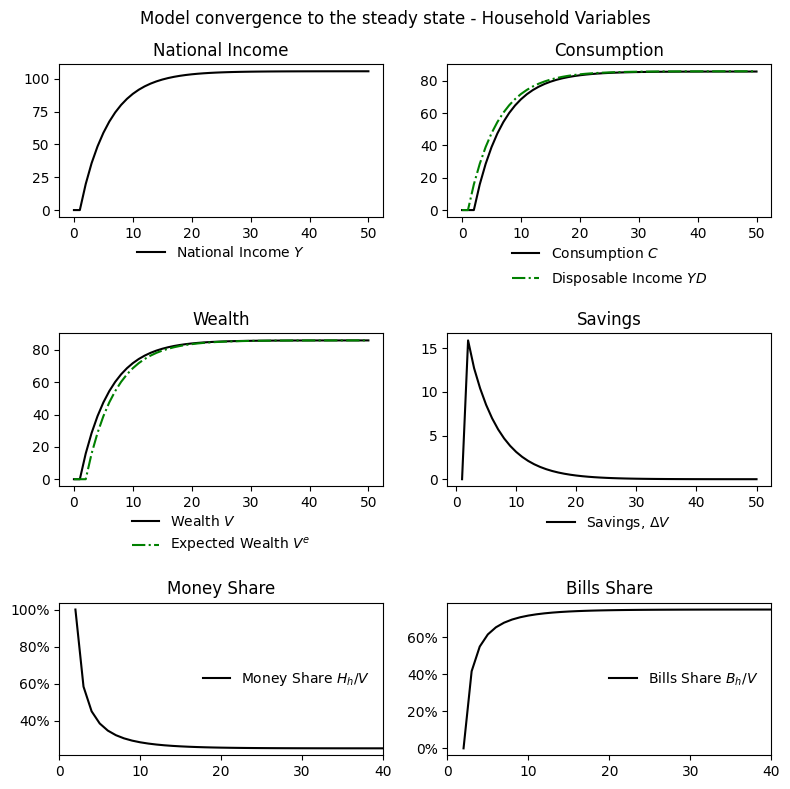

In [4]:
dfo = output.loc[:50]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(8, 8))

# National Income and Consumption
axs[0,0].plot(dfo.index, dfo['NationalIncome'], color='k', label=r'National Income $Y$')
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,0].set_title('National Income')
axs[0,1].plot(dfo.index, dfo['RealConsumptionHousehold'], color='k', label=r'Consumption $C$')
axs[0,1].plot(dfo.index, dfo['DisposableIncome'], color='g', linestyle='-.', label=r'Disposable Income $YD$')
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,1].set_title('Consumption')

# Wealth and Savings
axs[1,0].plot(dfo.index, dfo['Wealth'], color='k', label=r'Wealth $V$')
axs[1,0].plot(dfo.index, dfo['ExpectedWealth'], color='g', linestyle='-.', label=r'Expected Wealth $V^e$')
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,0].set_title('Wealth')
axs[1,1].plot(dfo.index, dfo['Wealth'].diff(), color='k', label=r'Savings, $\Delta V$')
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,1].set_title('Savings')

# Money Share and Bills Share
axs[2,0].plot(dfo.index, dfo['HouseholdMoneyStock'] / dfo['Wealth'], color='k', linestyle='-', label='Money Share $H_h/V$')
axs[2,0].legend(loc='center right', frameon=False)
axs[2,0].set_xlim(0,40)
axs[2,0].set_title('Money Share')
axs[2,0].yaxis.set_major_formatter(PercentFormatter(1))

# Right panel - Bills share
axs[2,1].plot(dfo.index, dfo['HouseholdBillStock'] / dfo['Wealth'], color='k', linestyle='-', label='Bills Share $B_h/V$')
axs[2,1].legend(loc='center right', frameon=False)
axs[2,1].set_xlim(0,40)
axs[2,1].set_title('Bills Share')
axs[2,1].yaxis.set_major_formatter(PercentFormatter(1))


fig.suptitle('Model convergence to the steady state - Household Variables')
plt.tight_layout()
plt.show()


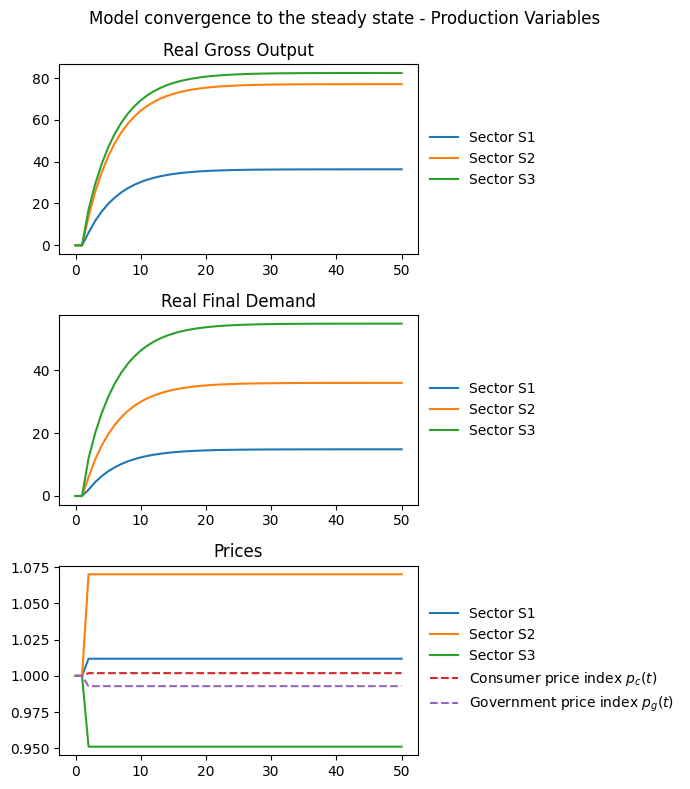

In [5]:
dfo = output.loc[:50]

fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(7, 8))

# National Income and Consumption
for s in dfo["RealGrossOutput"].columns:
    axs[0].plot(dfo.index, dfo['RealGrossOutput'][s], label=f"Sector {s}")
axs[0].set_title('Real Gross Output')

for s in dfo["RealFinalDemand"].columns:
    axs[1].plot(dfo.index, dfo['RealFinalDemand'][s], label=f"Sector {s}")
axs[1].set_title('Real Final Demand')

for s in dfo["Prices"].columns:
    axs[2].plot(dfo.index, dfo['Prices'][s], label=f"Sector {s}")
axs[2].plot(dfo.index, dfo["ConsumerPriceIndex"], linestyle="--", label=f"Consumer price index $p_c(t)$")
axs[2].plot(dfo.index, dfo["GovernmentPriceIndex"], linestyle="--", label=f"Government price index $p_g(t)$")
axs[2].set_title('Prices')

for ax in axs:
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)


fig.suptitle('Model convergence to the steady state - Production Variables')
plt.tight_layout()
plt.show()


### Perturbation 1: An increase of 100 points in the rate of interest on bills ($r$)

Following the convergence to the steady state, we can study the effects of an increase in the rate on bills by 100bps

`MacroStat` is set up to easily handle these scenarios. Much like in prior models, we simply define a new scenario `IncreaseInterestRate` and set the new rate to be 100 points higher $r=0.025+0.01$

In [6]:
model.parameters["scenario_trigger"] = 60
model.scenarios.add_scenario(
    name="IncreaseInterestRate",
    timeseries={"InterestRate":0.025 + 0.01}
)
model.simulate(scenario="IncreaseInterestRate")
output_rate_increase = model.variables.to_pandas()

Now we can see how the model reacts to the shock.

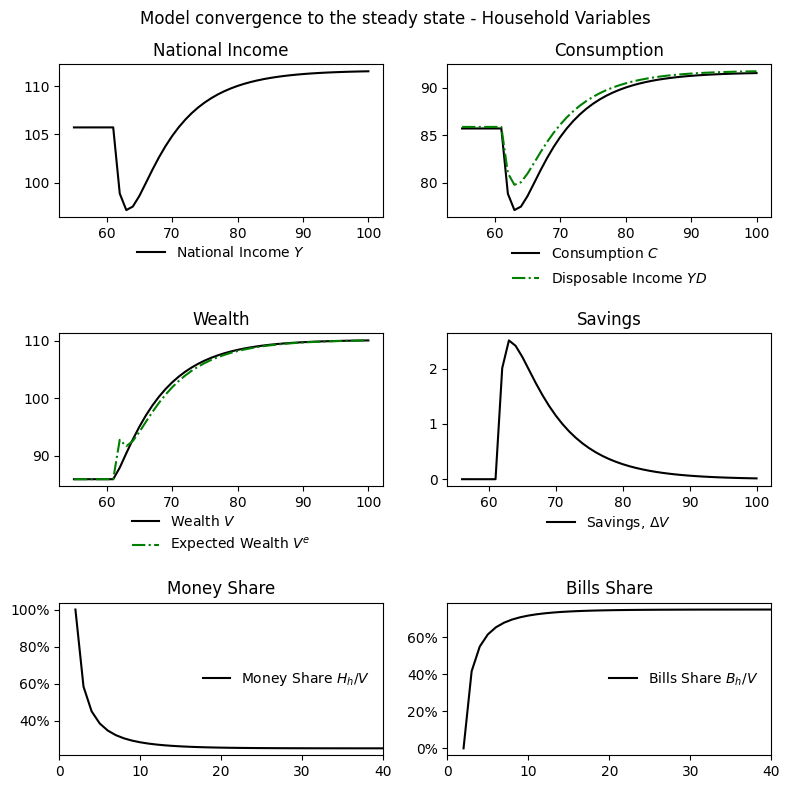

In [7]:
dfo = output_rate_increase.loc[55:]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(8, 8))

# National Income and Consumption
axs[0,0].plot(dfo.index, dfo['NationalIncome'], color='k', label=r'National Income $Y$')
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,0].set_title('National Income')
axs[0,1].plot(dfo.index, dfo['RealConsumptionHousehold'], color='k', label=r'Consumption $C$')
axs[0,1].plot(dfo.index, dfo['DisposableIncome'], color='g', linestyle='-.', label=r'Disposable Income $YD$')
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,1].set_title('Consumption')

# Wealth and Savings
axs[1,0].plot(dfo.index, dfo['Wealth'], color='k', label=r'Wealth $V$')
axs[1,0].plot(dfo.index, dfo['ExpectedWealth'], color='g', linestyle='-.', label=r'Expected Wealth $V^e$')
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,0].set_title('Wealth')
axs[1,1].plot(dfo.index, dfo['Wealth'].diff(), color='k', label=r'Savings, $\Delta V$')
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,1].set_title('Savings')

# Money Share and Bills Share
axs[2,0].plot(output.index, output['HouseholdMoneyStock'] / output['Wealth'], color='k', linestyle='-', label='Money Share $H_h/V$')
axs[2,0].legend(loc='center right', frameon=False)
axs[2,0].set_xlim(0,40)
axs[2,0].set_title('Money Share')
axs[2,0].yaxis.set_major_formatter(PercentFormatter(1))

# Right panel - Bills share
axs[2,1].plot(output.index, output['HouseholdBillStock'] / output['Wealth'], color='k', linestyle='-', label='Bills Share $B_h/V$')
axs[2,1].legend(loc='center right', frameon=False)
axs[2,1].set_xlim(0,40)
axs[2,1].set_title('Bills Share')
axs[2,1].yaxis.set_major_formatter(PercentFormatter(1))


fig.suptitle('Model convergence to the steady state - Household Variables')
plt.tight_layout()
plt.show()


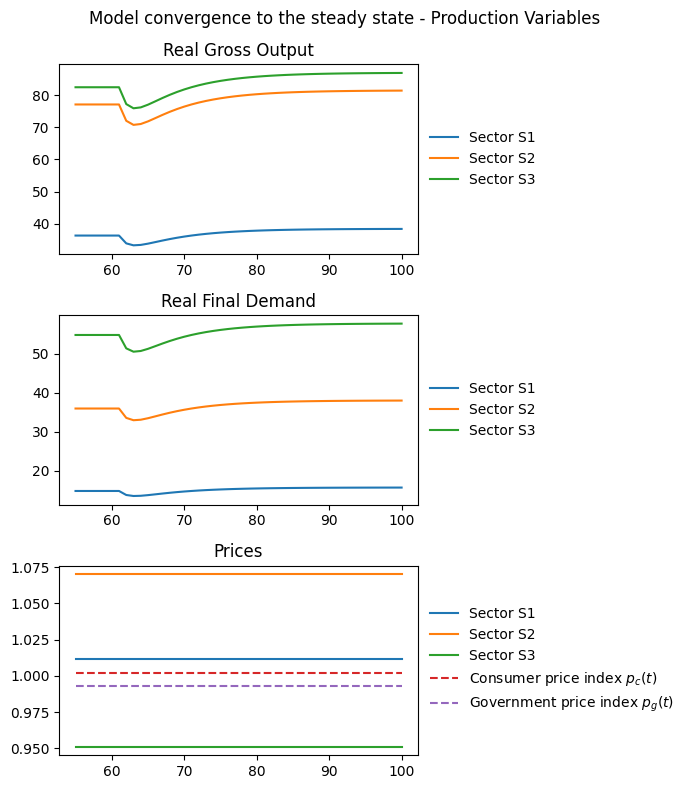

In [8]:
dfo = output_rate_increase.loc[55:]

fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(7, 8))

# National Income and Consumption
for s in dfo["RealGrossOutput"].columns:
    axs[0].plot(dfo.index, dfo['RealGrossOutput'][s], label=f"Sector {s}")
axs[0].set_title('Real Gross Output')

for s in dfo["RealFinalDemand"].columns:
    axs[1].plot(dfo.index, dfo['RealFinalDemand'][s], label=f"Sector {s}")
axs[1].set_title('Real Final Demand')

for s in dfo["Prices"].columns:
    axs[2].plot(dfo.index, dfo['Prices'][s], label=f"Sector {s}")
axs[2].plot(dfo.index, dfo["ConsumerPriceIndex"], linestyle="--", label=f"Consumer price index $p_c(t)$")
axs[2].plot(dfo.index, dfo["GovernmentPriceIndex"], linestyle="--", label=f"Government price index $p_g(t)$")
axs[2].set_title('Prices')

for ax in axs:
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)


fig.suptitle('Model convergence to the steady state - Production Variables')
plt.tight_layout()
plt.show()


### Perturbation 2: An increate in government spending

In [9]:
model.parameters["scenario_trigger"] = 60
model.scenarios.add_scenario(
    name="GovSpending",
    timeseries={"GovernmentDemand":25}
)
model.simulate(scenario="GovSpending")
output= model.variables.to_pandas()
dfo = output.loc[55:]

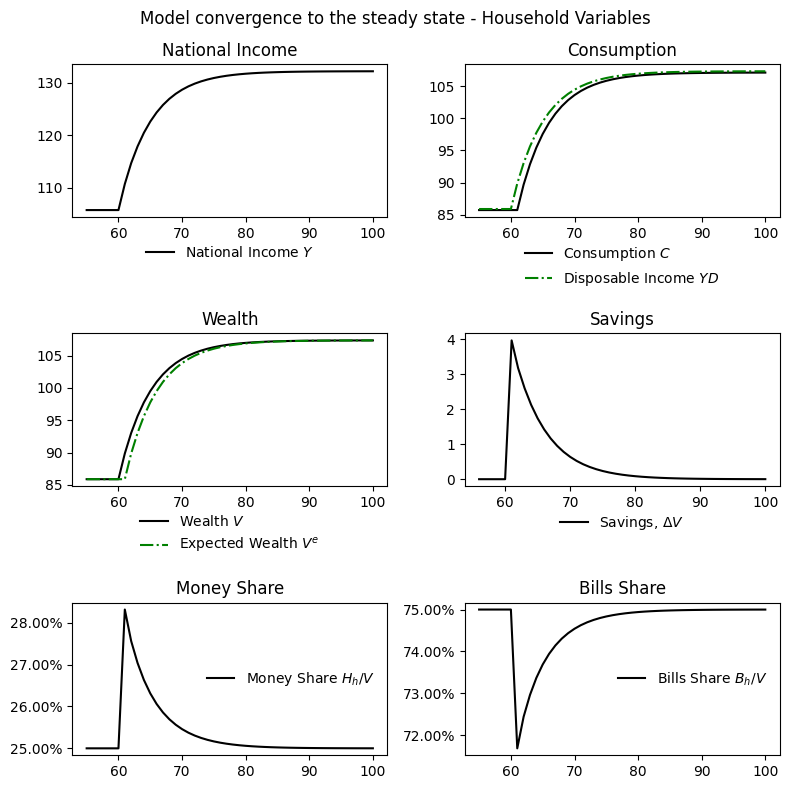

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(8, 8))

# National Income and Consumption
axs[0,0].plot(dfo.index, dfo['NationalIncome'], color='k', label=r'National Income $Y$')
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,0].set_title('National Income')
axs[0,1].plot(dfo.index, dfo['RealConsumptionHousehold'], color='k', label=r'Consumption $C$')
axs[0,1].plot(dfo.index, dfo['DisposableIncome'], color='g', linestyle='-.', label=r'Disposable Income $YD$')
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,1].set_title('Consumption')

# Wealth and Savings
axs[1,0].plot(dfo.index, dfo['Wealth'], color='k', label=r'Wealth $V$')
axs[1,0].plot(dfo.index, dfo['ExpectedWealth'], color='g', linestyle='-.', label=r'Expected Wealth $V^e$')
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,0].set_title('Wealth')
axs[1,1].plot(dfo.index, dfo['Wealth'].diff(), color='k', label=r'Savings, $\Delta V$')
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,1].set_title('Savings')

# Money Share and Bills Share
axs[2,0].plot(dfo.index, dfo['HouseholdMoneyStock'] / dfo['Wealth'], color='k', linestyle='-', label='Money Share $H_h/V$')
axs[2,0].legend(loc='center right', frameon=False)
axs[2,0].set_title('Money Share')
axs[2,0].yaxis.set_major_formatter(PercentFormatter(1))

# Right panel - Bills share
axs[2,1].plot(dfo.index, dfo['HouseholdBillStock'] / dfo['Wealth'], color='k', linestyle='-', label='Bills Share $B_h/V$')
axs[2,1].legend(loc='center right', frameon=False)
axs[2,1].set_title('Bills Share')
axs[2,1].yaxis.set_major_formatter(PercentFormatter(1))


fig.suptitle('Model convergence to the steady state - Household Variables')
plt.tight_layout()
plt.show()


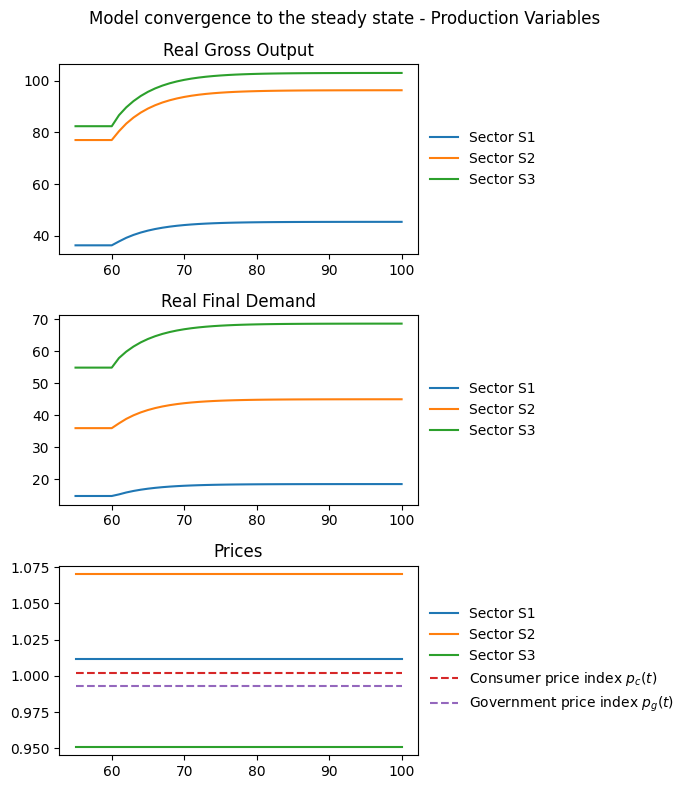

In [11]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(7, 8))

# National Income and Consumption
for s in dfo["RealGrossOutput"].columns:
    axs[0].plot(dfo.index, dfo['RealGrossOutput'][s], label=f"Sector {s}")
axs[0].set_title('Real Gross Output')

for s in dfo["RealFinalDemand"].columns:
    axs[1].plot(dfo.index, dfo['RealFinalDemand'][s], label=f"Sector {s}")
axs[1].set_title('Real Final Demand')

for s in dfo["Prices"].columns:
    axs[2].plot(dfo.index, dfo['Prices'][s], label=f"Sector {s}")
axs[2].plot(dfo.index, dfo["ConsumerPriceIndex"], linestyle="--", label=f"Consumer price index $p_c(t)$")
axs[2].plot(dfo.index, dfo["GovernmentPriceIndex"], linestyle="--", label=f"Government price index $p_g(t)$")
axs[2].set_title('Prices')

for ax in axs:
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)


fig.suptitle('Model convergence to the steady state - Production Variables')
plt.tight_layout()
plt.show()
